# stock6_lstm
## 概要
### 予測モデル
* 月～木曜日までの情報を元に、金曜日の始まり値が木曜の終値より上がるか下がるかを予測する
### 処理
* yahoo financeより株価データを取得する
* 株価データを用いて、予測モデルを構築する
  * 予測モデルの構築には、RNN（再帰的ニューラルネットワーク）の１つの手法であるLSTMを用いる
* 予測モデルを評価する
## 参考
### キノコード：株価のデータ分析(6)
* https://youtu.be/asfWaVpCyl8
* https://kino-code.com/python-stock-price/
### install packages
* pip install pandas_datareader
* pip install tensorflow

## 株価データを読み込み目的変数を追加する

In [1]:
# 日経平均データ（~N225）の取得
from pandas_datareader import data as pdr
import yfinance as yf
ticker = '^N225'
start = '1965-01-05'
end = '2021-10-22'

yf.pdr_override()
df = pdr.get_data_yahoo(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [2]:
# 各カラムの詳細確認（欠損有無の確認）
# + サンプルコード（キノコード）と合わせるためのデータ整形
#df.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
df.drop(['Close', 'Volume'], axis=1, inplace=True)
df.rename(columns={'Adj Close': 'Close'}, inplace=True)
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13970 entries, 0 to 13969
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    13970 non-null  datetime64[ns]
 1   Open    13970 non-null  float64       
 2   High    13970 non-null  float64       
 3   Low     13970 non-null  float64       
 4   Close   13970 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 545.8 KB


In [3]:
# 曜日情報を追加(月曜:0, 火曜:1, 水曜:2, 木曜:3, 金曜:4、土曜:5、日曜:6)
df['weekday'] = df['Date'].dt.weekday

# 初めの月曜日となる1965/1/4を基準（第0週）として週数を追加
from datetime import datetime
from datetime import timedelta
start = datetime(1965,1,4)
df['weeks'] = (df['Date'] - start) // timedelta(weeks=1)

# カラムの並べ替え
df = df[['Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close']]

# データの並び替え
df.sort_values(by='Date', ascending=True, inplace=True)
# 日付をインデックスにセット
df.set_index(keys='Date', inplace=True)
df

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
1965-01-05,0,1,1257.719971,1257.719971,1257.719971,1257.719971
1965-01-06,0,2,1263.989990,1263.989990,1263.989990,1263.989990
1965-01-07,0,3,1274.270020,1274.270020,1274.270020,1274.270020
1965-01-08,0,4,1286.430054,1286.430054,1286.430054,1286.430054
1965-01-12,1,1,1288.540039,1288.540039,1288.540039,1288.540039
...,...,...,...,...,...,...
2021-10-15,2962,4,29082.349609,28726.220703,28787.259766,29068.630859
2021-10-18,2963,0,29144.330078,28924.400391,29093.820312,29025.460938
2021-10-19,2963,1,29272.490234,29075.369141,29117.279297,29215.519531


In [4]:
#カラム情報を1行上にずらしたデータフレームを作成する
df_shift = df.shift(-1)

#翌日の始値と本日の終値の差分を追加する
df['delta_Close'] = df_shift['Close'] - df['Close']

#目的変数Upを追加する(翌日の終値が上がる場合1、それ以外は0とする)、'delta_Close'カラムの削除
import warnings
warnings.simplefilter('ignore')
df['Up'] = 0
df['Up'][df['delta_Close'] > 0] = 1
df = df.drop('delta_Close', axis=1)
df

,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
1965-01-05,0,1,1257.719971,1257.719971,1257.719971,1257.719971,1
1965-01-06,0,2,1263.989990,1263.989990,1263.989990,1263.989990,1
1965-01-07,0,3,1274.270020,1274.270020,1274.270020,1274.270020,1
1965-01-08,0,4,1286.430054,1286.430054,1286.430054,1286.430054,1
1965-01-12,1,1,1288.540039,1288.540039,1288.540039,1288.540039,0
...,...,...,...,...,...,...,...
2021-10-15,2962,4,29082.349609,28726.220703,28787.259766,29068.630859,0
2021-10-18,2963,0,29144.330078,28924.400391,29093.820312,29025.460938,1
2021-10-19,2963,1,29272.490234,29075.369141,29117.279297,29215.519531,1


## データの全体像をつかむ

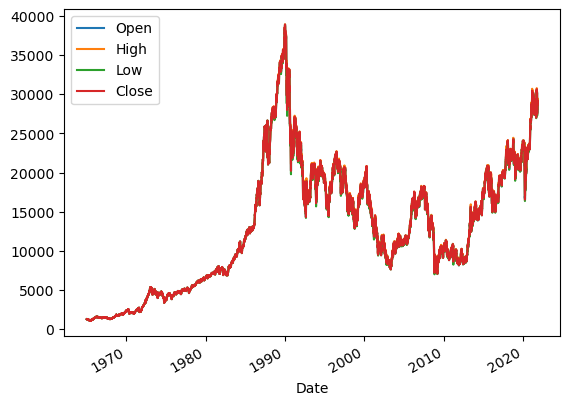

In [5]:
# 'Open', 'High', 'Low', 'Close'グラフ化のためにカラム抽出
df_new = df[['Open', 'High', 'Low', 'Close']]

# 時系列折れ線グラフの作成
from matplotlib import pyplot as plt
df_new.plot(kind='line')
plt.show()

## 特徴量を追加する

In [6]:
# 終値の前日比の追加
df_shift = df.shift(1)

df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
1965-01-05,0,1,1257.719971,1257.719971,1257.719971,1257.719971,1,NaN
1965-01-06,0,2,1263.989990,1263.989990,1263.989990,1263.989990,1,0.004985
1965-01-07,0,3,1274.270020,1274.270020,1274.270020,1274.270020,1,0.008133
1965-01-08,0,4,1286.430054,1286.430054,1286.430054,1286.430054,1,0.009543
1965-01-12,1,1,1288.540039,1288.540039,1288.540039,1288.540039,0,0.001640
...,...,...,...,...,...,...,...,...
2021-10-15,2962,4,29082.349609,28726.220703,28787.259766,29068.630859,0,0.018133
2021-10-18,2963,0,29144.330078,28924.400391,29093.820312,29025.460938,1,-0.001485
2021-10-19,2963,1,29272.490234,29075.369141,29117.279297,29215.519531,1,0.006548


In [7]:
# 始値と終値の差分を追加
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
1965-01-05,0,1,1257.719971,1257.719971,1257.719971,1257.719971,1,NaN,0.000000
1965-01-06,0,2,1263.989990,1263.989990,1263.989990,1263.989990,1,0.004985,0.000000
1965-01-07,0,3,1274.270020,1274.270020,1274.270020,1274.270020,1,0.008133,0.000000
1965-01-08,0,4,1286.430054,1286.430054,1286.430054,1286.430054,1,0.009543,0.000000
1965-01-12,1,1,1288.540039,1288.540039,1288.540039,1288.540039,0,0.001640,0.000000
...,...,...,...,...,...,...,...,...,...
2021-10-15,2962,4,29082.349609,28726.220703,28787.259766,29068.630859,0,0.018133,-281.371094
2021-10-18,2963,0,29144.330078,28924.400391,29093.820312,29025.460938,1,-0.001485,68.359375
2021-10-19,2963,1,29272.490234,29075.369141,29117.279297,29215.519531,1,0.006548,-98.240234


### 不要データの削除
* 各週で月曜日から金曜日までのデータが揃っている週だけ使用する。
* 祝日や年末年始など株取引が行われていない日はデータがない為、5日分のデータが揃っていない週が存在する。
* 各週毎に何日分のデータが存在しているのかを調べて、5日分揃っている週のデータのみを持ってくる。
* 週番号は0から2963まで連番で有ると考えられ、0から順番に処理すれば良いと考えられるが、万が一抜けている週が存在して居ても処理が行えるように、あえて週番号を抜き出したリスト(list_weeks)を作成する。

In [8]:
# 週番号をリストに格納
list_weeks = []
list_weeks = df['weeks'].unique()

# 各週ごとの日数を入力
df['week_days'] = 0

for i in list_weeks:
  df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])







In [9]:
# 月曜〜金曜まで5日分データのある週だけデータを取り出す
df = df[df['week_days'] == 5]

#金曜日のデータを削除する(weekday:4となるデータ)
df = df[df['weekday'] != 4]

# 不要カラムの削除と並べ替え
df = df[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body', 'Up']]
df

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
1965-01-18,0,1271.680054,1271.680054,1271.680054,1271.680054,-0.013819,0.000000,0
1965-01-19,1,1270.339966,1270.339966,1270.339966,1270.339966,-0.001054,0.000000,0
1965-01-20,2,1268.880005,1268.880005,1268.880005,1268.880005,-0.001149,0.000000,1
1965-01-21,3,1270.459961,1270.459961,1270.459961,1270.459961,0.001245,0.000000,0
1965-01-25,0,1249.719971,1249.719971,1249.719971,1249.719971,-0.009597,0.000000,0
...,...,...,...,...,...,...,...,...
2021-10-07,3,28015.109375,27607.970703,27665.970703,27678.210938,0.005425,-12.240234,1
2021-10-11,0,28581.359375,27893.320312,27977.570312,28498.199219,0.016017,-520.628906,0
2021-10-12,1,28468.880859,28166.380859,28458.880859,28230.609375,-0.009390,228.271484,0


### 学習データと検証データに分割する
* 2018年から2020年を学習データ、2021年以降を検証データとして分割する

In [10]:
# 学習データを2018-01-01〜2020-12-31の期間としdf_trainに入力する
df_train = df['2018-01-01' : '2020-12-31']

# 検証データを2021-01-01以降としてとしてdf_valに入力する
df_val = df['2021-01-01' : ]

In [11]:
# 学習データを説明変数(X_train)と目的変数(y_train)に分ける
X_train = df_train[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_train = df_train['Up']

# 学習データの説明変数を確認
X_train

,weekday,High,Low,Open,Close,Close_ratio,Body
Date,,,,,,,
2018-01-15,0,23833.269531,23685.019531,23827.980469,23714.880859,0.002581,113.099609
2018-01-16,1,23962.070312,23701.830078,23721.169922,23951.810547,0.009991,-230.640625
2018-01-17,2,23891.630859,23739.169922,23783.419922,23868.339844,-0.003485,-84.919922
2018-01-18,3,24084.419922,23699.470703,24078.929688,23763.369141,-0.004398,315.560547
2018-01-22,0,23816.330078,23697.810547,23797.839844,23816.330078,0.000347,-18.490234
...,...,...,...,...,...,...,...
2020-12-17,3,26843.050781,26676.279297,26744.500000,26806.669922,0.001841,-62.169922
2020-12-21,0,26905.669922,26533.630859,26834.099609,26714.419922,-0.001830,119.679688
2020-12-22,1,26639.990234,26361.660156,26559.330078,26436.390625,-0.010407,122.939453


In [12]:
# 検証データを説明変数(X_val)と目的変数(y_val)に分ける
X_val = df_val[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_val = df_val['Up']

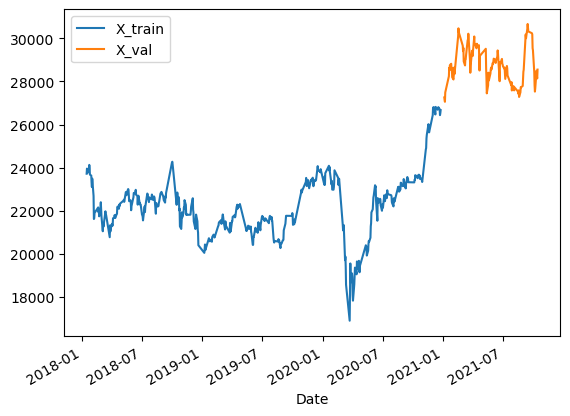

In [13]:
# 学習データと検証データの終値(Close)の折れ線グラフ作成
X_train['Close'].plot(kind='line')
X_val['Close'].plot(kind='line')

# グラフの凡例を設定
plt.legend(['X_train', 'X_val'])

# グラフの表示
plt.show()

### データを整える
* 予測モデルに学習をさせるために、データを整える
* 説明変数は各週毎の月曜日から木曜日の４日間をセットとして一つにまとめる
* また、目的変数は翌日の金曜日の始値が上がるか下がるかを示す木曜日のデータを抜き出す
* 機械学習を行うためには、説明変数と目的変数の数を揃える必要がある
### 標準化
* 説明変数を抜き出す期間により、株価の金額や変動量が異なる
* 抜き出している期間内においてデータの大きさや変動幅が大きく異なっている場合、機械学習では予測が正しく行えない事がある
* このような場合に標準化という処理を行うことが有る
* この処理を行うことで、平均が0で±3以内程度の範囲に収める事が出来るために、機械は計算の処理がし易くなり、また予測精度が向上する事もある
### 処理概要
* この4日毎にデータを抜き出して標準化を行うための処理に、sklearnのpreprocessingというライブラリのStandardScalerという関数を使う
* この関数を用いて、for文の繰り返し処理を行う関数を定義する
* また今回、機械学習に使用する予測モデルはLSTMというニューラルネットのモデルを使用する
* このモデルではnumpy配列という形式のデータを用る

In [14]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 4日ごとにデータを抜き出して、標準化とnumpy配列に変換する関数(std_to_np)の定義
def std_to_np(df):
    df_list = []
    df = np.array(df)
    for i in range(0, len(df) - 3, 4):
        df_s = df[i:i+4]
        scl = StandardScaler()
        df_std = scl.fit_transform(df_s)
        df_list.append(df_std)
    return np.array(df_list)

In [15]:
# 学習データと検証データの説明変数に関数(std_to_np)を実行
X_train_np_array = std_to_np(X_train)
X_val_np_array = std_to_np(X_val)

# 学習データと検証データの形の確認
print(X_train_np_array.shape)
print(X_val_np_array.shape)

(120, 4, 7)
(33, 4, 7)


In [16]:
# 学習データ、検証データの目的変数の間引き
# 週の4日目(木曜日)のデータだけ抜き出す
y_train_new = y_train[3::4]
y_val_new = y_val[3::4]

# 間引き後の学習データと検証データの目的変数を確認
print(len(y_train_new))
print(len(y_val_new))

120
33


### 予測モデルの作成
* ニューラルネットの1種のLSTMを用いて予測モデルの作成と、検証データを用いた予測精度の検証を行う
* LSTMを使用するために、kerasのライブラリを使用する
* kerasを使用するために、tensorflowをインストールしておく必要がある

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [18]:
# LSTM構築とコンパイル関数
def lstm_comp(df):
    # 入力層/中間層/出力層のネットワークを構築
    model = Sequential()
    model.add(LSTM(256, activation='relu', batch_input_shape=(None, df.shape[1], df.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # ネットワークのコンパイル
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

### 時系列分割の交差検証
* 交差検証の手法には複数存在するが、今回の様な時系列のデータで過去のデータを用いて未来を予測する場合は、時系列分割の交差検証を用いるのが一般的である
* 今回は学習データを5分割し、学習データの長さを変更したものと学習データより未来の検証データを組み合わせることを繰り返して、合計4回の学習、予測と精度検証を行う
* これらのスコアの平均値から、モデルが予測に使用できるかの判断を行う。
### 処理内容
1. splitメソッドを用いて学習データを分割し、交差検証用の学習データと検証データを作成
1. 先に定義したlstm_comp関数よりLSTMモデルを作成
1. 交差検証用の学習データより学習
1. 検証データの説明変数を用いて予測
1. 予測結果の2値化
1. 検証データの目的変数(正解データ)を用いて、予測結果の精度算出と表示
1. 予測精度のスコアをリストに格納

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

In [20]:
valid_scores = []
tscv = TimeSeriesSplit(n_splits=4)

for fold, (train_indices, valid_indices) in enumerate(tscv.split(X_train_np_array)):
    X_train, X_valid = X_train_np_array[train_indices], X_train_np_array[valid_indices]
    y_train, y_valid = y_train_new[train_indices], y_train_new[valid_indices]

    # LSTM構築とコンパイル関数にX_trainを渡し、変数modelに代入
    model = lstm_comp(X_train)

    # モデル学習
    model.fit(X_train, y_train, epochs=10, batch_size=64)

    # 予測
    y_valid_pred = model.predict(X_valid)

    # 予測結果の2値化
    y_valid_pred = np.where(y_valid_pred < 0.5, 0, 1)

    # 予測精度の算出と表示
    score = accuracy_score(y_valid, y_valid_pred)
    print(f'fold {fold} MAE: {score}')

    # 予測精度スコアをリストに格納
    valid_scores.append(score)

Epoch 1/10
1/1 [==============================] - 1s 829ms/step - loss: 0.6963 - accuracy: 0.3750
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6903 - accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6877 - accuracy: 0.6250
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6813 - accuracy: 0.5417
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6871 - accuracy: 0.5417
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6762 - accuracy: 0.5417
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6738 - accuracy: 0.5417
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6746 - accuracy: 0.5000
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6701 - accuracy: 0.5417
Epoch 10/10
1/1 [==============================] - 0s 95ms/step
fold 0 MAE: 0.5
Epoch 1/10
1/1 [==============================] - 1s 7

In [21]:
print(f'valid_scores: {valid_scores}')
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

valid_scores: [0.5, 0.6666666666666666, 0.5416666666666666, 0.3333333333333333]
CV score: 0.5104166666666666


In [22]:
### このモデルに対して、2018年から2020年の学習データを用いて学習、予測する

# LSTM構築とコンパイル関数にX_train_np_arrayを渡し、変数modelに代入
model = lstm_comp(X_train_np_array)

# モデルの学習の実行
result = model.fit(X_train_np_array, y_train_new, epochs=10, batch_size=64)

# 作成したモデルより検証データを用いて予測を行う
pred = model.predict(X_val_np_array)
pred[:10]

Epoch 1/10
2/2 [==============================] - 1s 13ms/step - loss: 0.6922 - accuracy: 0.5167
Epoch 2/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6911 - accuracy: 0.5500
Epoch 3/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6887 - accuracy: 0.5250
Epoch 4/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6868 - accuracy: 0.5250
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6884 - accuracy: 0.5250
Epoch 6/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6865 - accuracy: 0.5500
Epoch 7/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6812 - accuracy: 0.6000
Epoch 8/10
2/2 [==============================] - 0s 13ms/step - loss: 0.6819 - accuracy: 0.6250
Epoch 9/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6782 - accuracy: 0.6417
Epoch 10/10
2/2 [==============================] - 0s 1ms/step


array([[0.4687311 ],
       [0.5050676 ],
       [0.51800394],
       [0.52860856],
       [0.5416849 ],
       [0.5441793 ],
       [0.4705324 ],
       [0.48864573],
       [0.46205094],
       [0.53240466]], dtype=float32)

In [23]:
# 予測結果を0もしくは1に修正（0.5を境にして、1に近いほど株価が上昇、0に近いほど株価が上昇しない）
pred = np.where(pred < 0.5, 0, 1)

# 実際の結果から予測値の正解率を計算する
from sklearn.metrics import accuracy_score
print('accuracy = ', accuracy_score(y_true=y_val_new, y_pred=pred))

accuracy =  0.5454545454545454


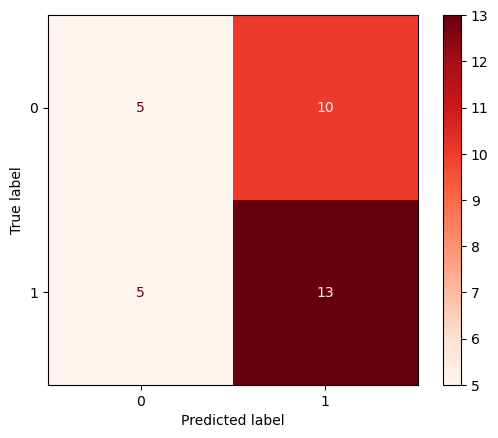

In [24]:
# 混同行列生成のためconfusion_matrixをインポート
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 混同行列を表示
cm = confusion_matrix(y_val_new, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)